# Установка библиотек и загрузка данных

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# если запускаем на Kaggle

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
pip install optuna

In [ ]:
!pip freeze | grep "numpy\|pandas\|lightgbm\|scikit-learn"

Библиотеки:

catboost==1.2.2

geopandas==0.14.3

lightgbm @ file:///tmp/lightgbm/lightgbm-4.2.0-py3-none-manylinux_2_31_x86_64.whl#sha256=26ed21477c12bb26edc4d6d51336cd43d5a8f7daf55ebbe27b0faf50ce96db23

msgpack-numpy==0.4.8

numpy @ file:///home/conda/feedstock_root/build_artifacts/numpy_1707225380409/work/dist/numpy-1.26.4-cp310-cp310-linux_x86_64.whl#sha256=51131fd8fc130cd168aecaf1bc0ea85f92e8ffebf211772ceb16ac2e7f10d7ca

optuna==3.5.0

pandas==2.1.4

pandas-datareader==0.10.0

pandas-profiling==3.6.6

pandas-summary==0.2.0

pandasql==0.7.3

scikit-learn==1.2.2

scikit-learn-intelex==2024.1.0

seaborn==0.12.2

sklearn-pandas==2.2.0


In [ ]:
train_df = pd.read_parquet('/kaggle/input/train_data.pqt')
test_df = pd.read_parquet('/kaggle/input/test_data.pqt')
train_df.shape, test_df.shape

((600000, 93), (290120, 92))

# Заполняем пропуски в фичах и start_cluster(month_6)


Наиболее часто стартовый кластер за 6 месяц равен предыдущему.

В целом обычно кластер за n-ый месяц равен (n-1)-ому

In [ ]:
test_df['start_cluster'].fillna(method='ffill', inplace=True)

In [ ]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

Выделим фичи

In [ ]:
cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "start_cluster",
    "index_city_code", "ogrn_month", "ogrn_year"
]

In [ ]:
basic_col = ["id", "date", "end_cluster"]
num_feat = [col for col in train_df.columns if (col not in basic_col) and (col not in cat_cols)]

In [ ]:
# отмечаем категориальные фичи
train_df[cat_cols] = train_df[cat_cols].astype("category")
test_df[cat_cols] = test_df[cat_cols].astype("category")

Разделим трейн на обучающую и валидационную выборки

# Отбор признаков для обучения модели

In [ ]:
X = train_df.drop(["id", "date", "end_cluster"], axis=1)
y = train_df["end_cluster"]

x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

Обучаем базовую модель CatBoost для того, чтобы получить важности признаков

In [ ]:
simple_model = CatBoostClassifier(iterations=1000, verbose=True, learning_rate=0.1, random_state=42, depth=6, cat_features=cat_cols, task_type="GPU",loss_function='MultiClass')
simple_model.fit(x_train[selected_features], y_train)

model_importance = pd.DataFrame({'col': selected_features,
                  'importance': simple_model.get_feature_importance()}).sort_values('importance', ascending=False)
top_features = list(model_importance['col'])


In [ ]:
top_features = ['start_cluster', 'okved', 'index_city_code', 'channel_code', 'city', 'balance_amt_min', 'segment', 'balance_amt_max', 'ogrn_days_end_quarter', 'sum_of_paym_1y', 'ogrn_days_end_month', 'cnt_a_oper_1m', 'min_founderpres',
 'ogrn_exist_months', 'ogrn_month', 'ft_registration_date', 'ogrn_year', 'sum_of_paym_6m', 'max_founderpres', 'sum_deb_e_oper_3m', 'balance_amt_avg', 'sum_of_paym_2m', 'sum_cred_e_oper_3m', 'cnt_days_deb_e_oper_3m',
 'balance_amt_day_avg', 'cnt_cred_e_oper_3m', 'sum_cred_e_oper_1m', 'sum_cred_h_oper_3m', 'cnt_days_cred_e_oper_3m',
 'cnt_deb_e_oper_3m', 'sum_deb_h_oper_3m', 'cnt_a_oper_3m', 'sum_deb_f_oper_3m', 'cnt_cred_e_oper_1m', 'sum_deb_g_oper_3m', 'sum_deb_e_oper_1m',
 'cnt_cred_h_oper_3m', 'cnt_deb_h_oper_3m', 'sum_deb_d_oper_3m', 'cnt_deb_e_oper_1m', 'sum_deb_f_oper_1m', 'sum_deb_h_oper_1m',
 'cnt_days_cred_e_oper_1m', 'cnt_deb_g_oper_3m', 'cnt_days_cred_h_oper_3m', 'sum_cred_g_oper_3m', 'sum_c_oper_3m',
 'sum_a_oper_3m', 'sum_cred_h_oper_1m', 'city_type', 'cnt_deb_d_oper_3m', 'sum_deb_d_oper_1m', 'cnt_days_deb_e_oper_1m', 'cnt_deb_f_oper_3m', 'sum_deb_g_oper_1m', 'cnt_days_deb_h_oper_3m', 'cnt_days_deb_f_oper_3m',
 'cnt_c_oper_3m', 'cnt_days_deb_g_oper_3m', 'cnt_b_oper_1m', 'cnt_days_deb_h_oper_1m', 'cnt_days_cred_h_oper_1m',
 'cnt_deb_f_oper_1m', 'sum_cred_f_oper_3m', 'cnt_days_cred_g_oper_1m', 'cnt_cred_g_oper_3m', 'sum_cred_d_oper_3m', 'sum_b_oper_3m', 'sum_c_oper_1m', 'sum_a_oper_1m', 'cnt_deb_g_oper_1m', 'cnt_deb_h_oper_1m',
                'cnt_b_oper_3m', 'cnt_days_cred_f_oper_1m', 'cnt_c_oper_1m', 'cnt_days_deb_g_oper_1m',
                'cnt_days_deb_f_oper_1m', 'sum_cred_g_oper_1m', 'cnt_cred_h_oper_1m', 'cnt_cred_d_oper_1m', 'sum_b_oper_1m', 'cnt_deb_d_oper_1m', 'cnt_cred_f_oper_3m',
 'cnt_cred_d_oper_3m', 'sum_cred_f_oper_1m', 'cnt_cred_f_oper_1m', 'sum_cred_d_oper_1m', 'cnt_cred_g_oper_1m', 'cnt_days_cred_g_oper_3m', 'cnt_days_cred_f_oper_3m']

In [ ]:
selected_features = top_features[:80]
cat_feat = [col for col in selected_features if train_df[col].dtype.name!='float64']

col	importance

5	start_cluster	12.153636

3	okved	7.426447

6	index_city_code	5.355152

0	channel_code	5.189536

1	city	4.245877

11	balance_amt_min	4.008148

4	segment	3.575472

10	balance_amt_max	3.244023

14	ogrn_days_end_quarter	3.010206

21	sum_of_paym_1y	2.628968

13	ogrn_days_end_month	2.615332

17	min_founderpres	2.355324

18	ogrn_exist_months	2.277854

7	ogrn_month	2.272347

15	ft_registration_date	2.151408

8	ogrn_year	2.128810

Как считается метрика:

In [ ]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [ ]:
cluster_weights = pd.read_excel("/kaggle/input/cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

Построим зависимость weighted_roc_auc от числа фичей. Постепенно уменьшаем число фичей и обучаем модель, в какой-то момент качество решения начинает стремительно падать - это предельное количество фичей для работы модели

In [ ]:
from sklearn.model_selection import StratifiedKFold
from tqdm.auto import tqdm

In [ ]:
# считается долго

roc_auc_df = pd.DataFrame(columns=['num_features', 'roc_auc'])

for i in tqdm(range( len(top_features), 4, -3)):

    roc_tmp = []
    cat_feat = [col for col in top_features[:i] if train_df[col].dtype.name!='float64']
    model = CatBoostClassifier(iterations=1000, verbose=True,
                               learning_rate=0.1, random_state=42,
                               depth=6, cat_features=cat_feat,
                               task_type="GPU",loss_function='MultiClass')

    model.fit( x_train[top_features[:i]], y_train )

    preds_test = model.predict_proba(x_val[top_features[:i]])

    w_roc_auc =  weighted_roc_auc(y_val, preds_test, model.classes_, weights_dict)

    roc_auc_df.loc[len(roc_auc_df)] = [i, w_roc_auc]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


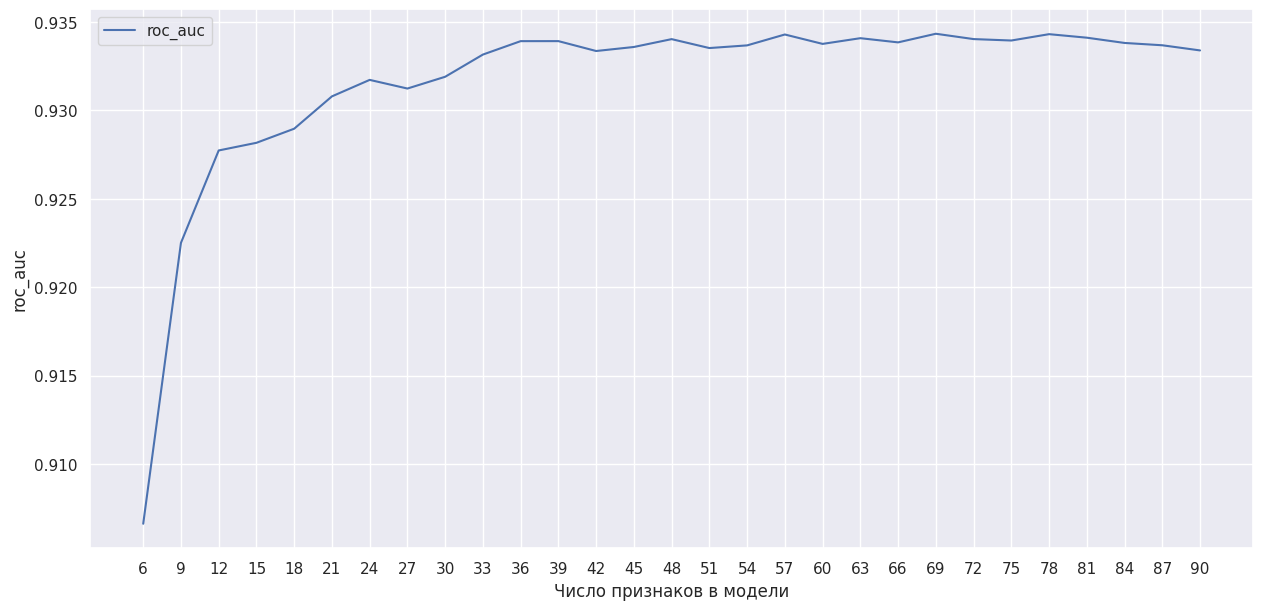

In [ ]:
roc_auc_df['num_features'] = roc_auc_df['num_features'].astype(int)

sns.set_theme(font_scale = 1, )
plt.figure(figsize=(15, 7))
sns.lineplot(data=roc_auc_df, x='num_features', y='roc_auc', label='roc_auc')
plt.grid(True)
plt.xlabel('Число признаков в модели')
plt.xticks(roc_auc_df['num_features'].astype(int))
plt.legend()

Видно, что метрика выходит на плато, когда число признаков достигает примерно 45-55 фичей

In [ ]:
selected_features = top_features[:51]
cat_feat = [col for col in selected_features if train_df[col].dtype.name!='float64']

# Оптимизация гиперпараметров

In [ ]:
import optuna

def objective(trial):

    # 1. разделяем случайным образом выборку X_cv, y_cv на обучающую, валидационную и тестовую
    x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    # 2. назначаем параметры и значения для перебора
    param = {
        "iterations": trial.suggest_int("iterations", 800, 1500),
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 1),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 100.0, log=True),  # L2 регуляризация
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 1),  # Сэмплирование признаков на уровне дерева
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),  # Температура бэггинга
        "random_strength": trial.suggest_float("random_strength", 0.0, 100.0),  # Случайность при построении деревьев
        "border_count": trial.suggest_int("border_count", 1, 600),  # border_count
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'random_seed': trial.suggest_int('random_seed', 1, 100)
    }

    # 3. обучаем модель с выбранными параметрами
    model_cv = CatBoostClassifier(**param, cat_features=cat_feat, task_type="GPU",loss_function='MultiClass')
    model_cv.fit(x_train[selected_features], y_train, verbose=False)

    # 4. делаем предсказание и возвращаем значение метрики
    preds = model_cv.predict_proba(x_val[selected_features])

    w_roc_auc = weighted_roc_auc(y_val, preds, model_cv.classes_, weights_dict)

    return w_roc_auc

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=1800)

# Получение лучших параметров
best_params = study.best_params
print("Best Params:", best_params)

Наиболее значимые фичи:  learning_rate,random_state и глубина дерева. Остальные параметры слабо влияют на производительность модели в данном случае

# Обучение модели

In [ ]:
model = CatBoostClassifier(iterations=1100,
                           verbose=True,
                           learning_rate=0.1,
                           random_state=42,
                           depth=6,
                           cat_features=cat_feat,
                           task_type="GPU",
                           loss_function='MultiClass')
model.fit(x_train[selected_features], y_train)

In [ ]:
y_pred_proba = model.predict_proba(x_val[selected_features])
y_pred_proba.shape

(120000, 17)

In [ ]:
# скор, который получается на валидации
weighted_roc_auc(y_val, y_pred_proba, model.classes_, weights_dict)

0.9556336265044427

Метрика на валидации 0.9556336265044427

# Прогноз на тестовой выборке

In [ ]:
sample_submission_df = pd.read_csv("/kaggle/input/sample_submission.csv")

In [ ]:
sample_submission_df.head()

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
1,200001,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
2,200002,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
3,200003,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
4,200004,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05


Обучаем на всем трейне, это немного улучшает метрику

In [ ]:
model_full = CatBoostClassifier(iterations=1100,
                           verbose=True,
                           learning_rate=0.1,
                           random_state=42,
                           depth=6,
                           cat_features=cat_feat,
                           task_type="GPU",
                           loss_function='MultiClass')
model_full.fit(X[selected_features], y)

In [ ]:
# для построения прогноза берем month_6
last_m_test_df = test_df[test_df["date"] == "month_6"]
last_m_test_df = last_m_test_df.drop(["id", "date"], axis=1)
test_pred_proba = model_full.predict_proba(last_m_test_df[selected_features])
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=model.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

In [ ]:
test_pred_proba_df.shape

(100000, 17)

In [ ]:
sample_submission_df

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.008290,0.017936,0.033384,0.029434,0.004381,0.000259,0.002000,0.001421,0.010209,0.002587,0.022398,0.000205,0.000961,5.501151e-07,0.003458,0.863068,0.000009
1,200001,0.005533,0.581520,0.000488,0.001432,0.000659,0.000036,0.000112,0.000008,0.001660,0.008938,0.000664,0.000096,0.001223,1.571752e-07,0.000298,0.397168,0.000165
2,200002,0.427380,0.003521,0.001955,0.135300,0.010503,0.000680,0.001319,0.023701,0.091856,0.008549,0.017422,0.014836,0.001274,1.681705e-06,0.049961,0.211623,0.000117
3,200003,0.018511,0.692422,0.000336,0.000629,0.000243,0.000384,0.000099,0.000158,0.000706,0.023218,0.002989,0.000076,0.001008,5.983105e-08,0.000145,0.259071,0.000006
4,200004,0.066491,0.168253,0.010378,0.009161,0.001071,0.001708,0.000263,0.000066,0.009495,0.065212,0.003598,0.000091,0.007802,4.052950e-07,0.000288,0.656121,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,299995,0.025461,0.367640,0.001300,0.006711,0.007496,0.000022,0.000592,0.000005,0.003770,0.000964,0.000853,0.001035,0.000178,8.701694e-06,0.000990,0.582795,0.000178
99996,299996,0.022782,0.044685,0.016422,0.048064,0.006579,0.000101,0.000333,0.000086,0.013382,0.003907,0.012318,0.005406,0.001050,3.303442e-06,0.006060,0.818437,0.000385
99997,299997,0.028238,0.017903,0.032413,0.061892,0.009019,0.000236,0.000627,0.000343,0.015594,0.004984,0.008794,0.000659,0.001808,4.034413e-06,0.027538,0.789947,0.000001
99998,299998,0.054958,0.239949,0.007651,0.043049,0.002264,0.000676,0.000926,0.000188,0.009583,0.015539,0.007505,0.002815,0.000844,3.281376e-06,0.014818,0.598863,0.000371


In [ ]:
sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("_submission_55_.csv", index=False)

In [ ]:
sample_submission_df.columns

Index(['id', '{other}', '{}', '{α, β}', '{α, γ}', '{α, δ}', '{α, ε, η}',
       '{α, ε, θ}', '{α, ε, ψ}', '{α, ε}', '{α, η}', '{α, θ}', '{α, λ}',
       '{α, μ}', '{α, π}', '{α, ψ}', '{α}', '{λ}'],
      dtype='object')

Несмотря на то, что данный код дает наилучший наш сабмит на паблик лидерборде, мы полагаем, что решения, полученное с помощью модели LGBMBoost или отдельных моделей для продуктов и/или кластеров  больше подходят для продвижения в продакшн. Не получилось за разумные сроки с помощью CatBoost на процессоре обучить модель, пришлось использовать видеокарты, что привело к небольшой нестабильности модели.